
Processing Global dataset...
  Using config: max_samples=2, n_estimators=200, if_max_samples=256
  Running ISER-A...
  Running ISER-S...

Processing Local dataset...
  Using config: max_samples=32, n_estimators=200, if_max_samples=128
  Running ISER-A...
  Running ISER-S...

Processing Dependency dataset...
  Using config: max_samples=4, n_estimators=200, if_max_samples=512
  Running ISER-A...
  Running ISER-S...


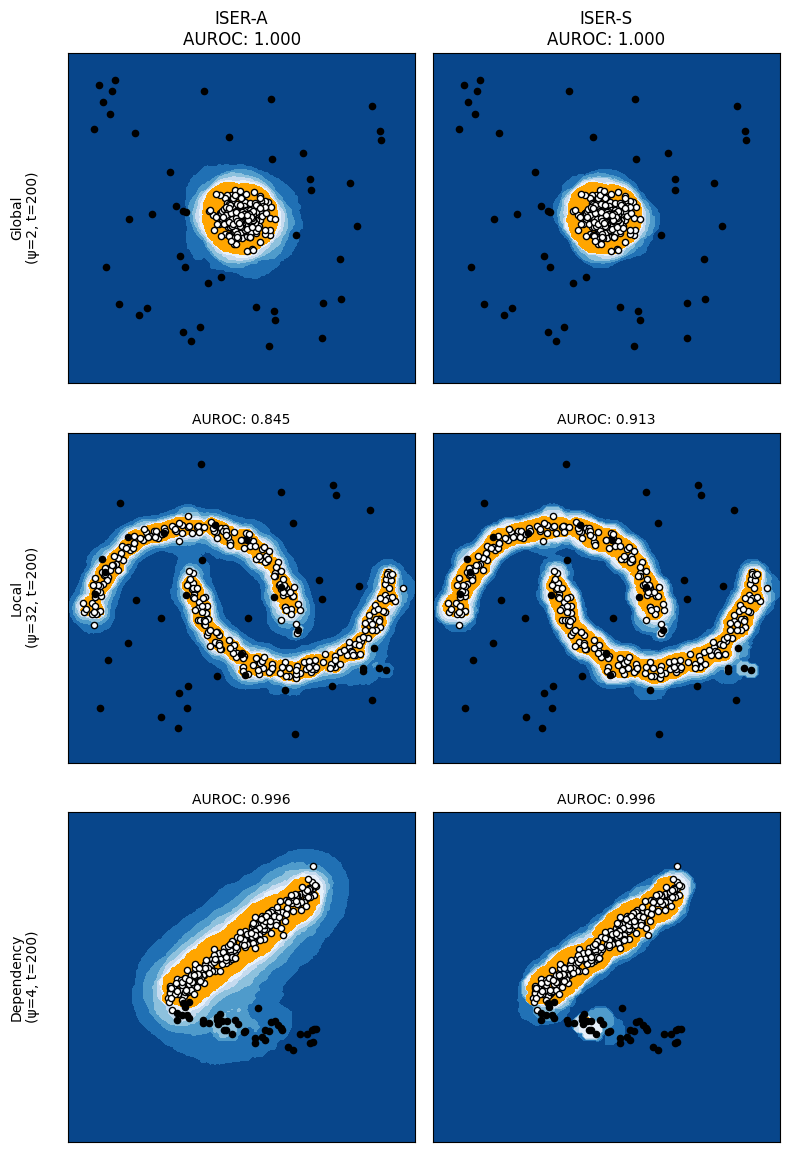


PERFORMANCE SUMMARY
Detailed Results:
   Dataset Algorithm  AUROC  AUCPR  max_samples  n_estimators  if_max_samples
    Global    ISER-A 1.0000 1.0000            2           200             256
    Global    ISER-S 1.0000 1.0000            2           200             256
     Local    ISER-A 0.8445 0.8029           32           200             128
     Local    ISER-S 0.9134 0.8273           32           200             128
Dependency    ISER-A 0.9961 0.9761            4           200             512
Dependency    ISER-S 0.9956 0.9723            4           200             512


In [ ]:
import numpy as np
import warnings
from numpy import percentile
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")
from sklearn.datasets import make_moons, make_blobs
from pyod.models.iforest import IForest
from pyod.models.inne import INNE
from ISER import ISER
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)

def create_cluster_anomaly_dataset(n_inliers, n_outliers, random_state=0):
    rng = np.random.RandomState(random_state)
    
    main_centers = [[0, 0], [3, 3], [-3, 3]]
    X_main = []
    for center in main_centers:
        cluster_size = n_inliers // len(main_centers)
        cluster_data = rng.multivariate_normal(
            center, [[0.3, 0], [0, 0.3]], cluster_size
        )
        X_main.append(cluster_data)
    X_main = np.vstack(X_main)
    
    anomaly_centers = [[5, -3], [-4, -4]]
    X_anomaly = []
    for center in anomaly_centers:
        cluster_size = n_outliers // len(anomaly_centers)
        cluster_data = rng.multivariate_normal(
            center, [[0.2, 0], [0, 0.2]], cluster_size
        )
        X_anomaly.append(cluster_data)
    X_anomaly = np.vstack(X_anomaly)
    
    return np.vstack([X_main, X_anomaly])

def create_dependency_anomaly_dataset(n_inliers, n_outliers, random_state=0):
    """创建dependency anomaly数据集：异常点违反了变量间的依赖关系"""
    rng = np.random.RandomState(random_state)

    x1 = rng.uniform(-3, 3, n_inliers)
    x2 = 0.8 * x1 + 1.5 + rng.normal(0, 0.3, n_inliers)  
    X_main = np.column_stack([x1, x2])
    
    x1_anomaly = rng.uniform(-3, 3, n_outliers)
    x2_anomaly = -0.2 * x1_anomaly - 2 + rng.normal(0, 0.3, n_outliers) 
    X_anomaly = np.column_stack([x1_anomaly, x2_anomaly])
    
    return np.vstack([X_main, X_anomaly])

datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    4 * (make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0] - np.array([0.5, 0.25])),
    create_dependency_anomaly_dataset(n_inliers, n_outliers)
]
dataset_configs = {
    "Global": {
        "max_samples": 2,
        "if_max_samples": 256,
        "n_estimators": 200,
        'random_state': 42, 
    },
    "Local": {
        "max_samples": 32,  
        "if_max_samples": 128,
        "n_estimators": 200,
        'random_state': 42,
    },
    "Dependency": {
        "max_samples": 4,  
        "n_estimators": 200,
        'random_state': 0,
        "if_max_samples": 512
    }
}

methods = ['ISER-A', 'ISER-S']

xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))
rng = np.random.RandomState(42)

def compute_anomaly_scores_and_metrics(X, algorithm, alg_name, y_true=None):
    """计算异常分数和性能指标，但不绘图"""
    algorithm.fit(X)
    
    if alg_name == 'ISER-A':
        scores_pred = algorithm.ISER_A(X) * -1
    elif alg_name == 'ISER-S':
        scores_pred = algorithm.ISER_S(X) * -1
    elif alg_name == 'ISER_IF':
        scores_pred = algorithm.ISER_IF(X) * -1
    else:
        scores_pred = algorithm.ISER_S(X) * -1
    
    auroc, aucpr = None, None
    if y_true is not None:
        auroc = roc_auc_score(y_true, -scores_pred)
        precision, recall, _ = precision_recall_curve(y_true, -scores_pred)
        aucpr = auc(recall, precision)
    
    threshold = percentile(scores_pred, 100 * outliers_fraction)
    
    if alg_name == 'ISER-A':
        Z = algorithm.ISER_A(np.c_[xx.ravel(), yy.ravel()]) * -1
    elif alg_name == 'ISER-S':
        Z = algorithm.ISER_S(np.c_[xx.ravel(), yy.ravel()]) * -1
    elif alg_name == 'ISER_IF':
        Z = algorithm.ISER_IF(np.c_[xx.ravel(), yy.ravel()]) * -1
    else:
        Z = algorithm.ISER_IF(np.c_[xx.ravel(), yy.ravel()]) * -1
    
    Z = Z.reshape(xx.shape)
    
    return scores_pred, threshold, Z, auroc, aucpr

results = {}
dataset_names = ["Global", "Local", "Dependency"]

prepared_datasets = []
y_trues = []

for i_dataset, X in enumerate(datasets):
    if i_dataset < 2:
        X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)
        y_true = np.zeros(len(X), dtype=int)
        y_true[-n_outliers:] = 1
    else:
        y_true = np.zeros(len(X), dtype=int)
        y_true[-n_outliers:] = 1
    
    prepared_datasets.append(X)
    y_trues.append(y_true)

fig, axes = plt.subplots(3, len(methods), figsize=(8, 12))
# fig.suptitle('ISER Anomaly Detection Results', fontsize=16, y=0.95)

all_results = []

for i_dataset, (X, y_true) in enumerate(zip(prepared_datasets, y_trues)):
    dataset_name = dataset_names[i_dataset]
    print(f"\nProcessing {dataset_name} dataset...")
    
    config = dataset_configs[dataset_name]
    print(f"  Using config: max_samples={config['max_samples']}, "
          f"n_estimators={config['n_estimators']}, "
          f"if_max_samples={config['if_max_samples']}")
    
    for j_method, alg_name in enumerate(methods):
        print(f"  Running {alg_name}...")
        
        algorithm = ISER(
            max_samples=config['max_samples'], 
            n_estimators=config['n_estimators'],
            if_max_samples=config['if_max_samples'],
            random_state=config['random_state']
            )
        
        scores_pred, threshold, Z, auroc, aucpr = compute_anomaly_scores_and_metrics(
            X, algorithm, alg_name, y_true
        )
        
        all_results.append({
            'Dataset': dataset_name,
            'Algorithm': alg_name,
            'AUROC': auroc,
            'AUCPR': aucpr,
            'max_samples': config['max_samples'],
            'n_estimators': config['n_estimators'],
            'if_max_samples': config['if_max_samples']
        })
        
        ax = axes[i_dataset, j_method]
        
        ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)
        ax.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors="orange")
        
        ax.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c="white", s=20, edgecolor="k")
        ax.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c="black", s=20, edgecolor="k")
        
        ax.set_xlim((-7, 7))
        ax.set_ylim((-7, 7))
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i_dataset == 0:  
            ax.set_title(f'{alg_name}\nAUROC: {auroc:.3f}', fontsize=12)
        else:
            ax.set_title(f'AUROC: {auroc:.3f}', fontsize=10)
        
        if j_method == 0:
            label_text = f'{dataset_name}\n(ψ={config["max_samples"]}, t={config["n_estimators"]})'
            ax.set_ylabel(label_text, fontsize=10, rotation=90, labelpad=20)

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.15, wspace=0.05)
plt.show()

print(f"\n{'='*80}")
print("PERFORMANCE SUMMARY")
print(f"{'='*80}")

summary_df = pd.DataFrame(all_results)

print("Detailed Results:")
print(summary_df.to_string(index=False, float_format='%.4f'))